In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import seaborn as sns
from dotmap import DotMap
from pathlib import Path
from collections.abc import Mapping, Callable

from IPython.display import display

In [124]:
DATA = Path("./data")
df_flags = pd.read_csv(
    DATA / "definitions_and_standards/flags.csv",
    keep_default_na=False,
    index_col="Flag"
)
# Helper function

def join_flags(df, filepath, df_flags):
    df["Flag"] = pd.read_csv(filepath, encoding="latin1", usecols=["Flag"], keep_default_na=False)
    return df.merge(df_flags, on="Flag").drop(columns="Flag").rename(columns={"Flags": "Flag"})

def split_on(df, column, rename={}, only_named=False):
    """
    Splits a dataframe in multiple dataframe based on the value of a columne
    
    Args:
        df: dataframe to spli
        column: name of the column to split on
        rename (optional): mapping or callable that rename values to name in the final dictionary
        only_named (False): keep only dataframe with a value in column that is renamed
    
    Returns:
        A dictionnary mapping unique values in df[column] to the dataframe with that value.
        Value (i.e. dict keys) can be renamed by the rename argument. A callable can return None to not rename it.
    """
    result = DotMap(_dynamic=False)
    for value in df[column].unique():
        if callable(rename):
            name = rename(value)
        elif isinstance(rename, Mapping):
            name = rename.get(value)
        else:
            name = None
        if name is None and only_named:
            continue
        result[name or value] = df[ df[column] == value].drop(columns=column)
    return result

def select_on(df, columns, dict_elements):
    for column in columns:
        elements = dict_elements[column]
        df = df[df[column].isin(elements)]
    return df

In [125]:
Enteric_Fermentation_PATH = DATA / "global-food-agriculture-statistics/current_FAO/raw_files/Emissions_Agriculture_Enteric_Fermentation_E_All_Data_(Norm).csv"
Manure_soils_PATH = DATA / "global-food-agriculture-statistics/current_FAO/raw_files/Emissions_Agriculture_Manure_applied_to_soils_E_All_Data_(Norm).csv"
Manure_management_PATH = DATA / "global-food-agriculture-statistics/current_FAO/raw_files/Emissions_Agriculture_Manure_Management_E_All_Data_(Norm).csv"
Manure_pasture_PATH = DATA / "global-food-agriculture-statistics/current_FAO/raw_files/Emissions_Agriculture_Manure_left_on_pasture_E_All_Data_(Norm).csv"
df_entric_fermentation = pd.read_csv(Enteric_Fermentation_PATH, encoding="ISO-8859-1")
df_manure_soils = pd.read_csv(Manure_soils_PATH,encoding="ISO-8859-1")
df_manure_management = pd.read_csv(Manure_management_PATH,encoding="ISO-8859-1")
df_manure_pasture = pd.read_csv(Manure_pasture_PATH,encoding="ISO-8859-1")


In [126]:
df_entric_fermentation = join_flags(df_entric_fermentation,\
                                    Enteric_Fermentation_PATH,\
                                    df_flags)
df_manure_soils = join_flags(df_manure_soils,\
                                    Manure_soils_PATH,\
                                    df_flags)
df_manure_management = join_flags(df_manure_management,\
                                    Manure_management_PATH,\
                                    df_flags)
df_manure_pasture = join_flags(df_manure_pasture,\
                                    Manure_pasture_PATH,\
                                    df_flags)


In [127]:
df_entric_fermentation.isna().any()

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year Code       False
Year            False
Unit            False
Value           False
Flag            False
dtype: bool

In [128]:
df_entric_fermentation.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,1961,Head,1300000.0,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,1962,Head,851850.0,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,1963,Head,1001112.0,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,1965,Head,1300000.0,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,1966,Head,1200000.0,Official data


# Table description
The table ‘Enteric Fermentation’ contains the following data:
country-level GHG(Greenhouse gaz) emissions in both Gg CH4 and Gg CO2eq, by animal categories and their aggregates, as well as their total; implied emission factors; and activity data.

In [129]:
df_entric_fermentation.columns

Index(['Country Code', 'Country', 'Item Code', 'Item', 'Element Code',
       'Element', 'Year Code', 'Year', 'Unit', 'Value', 'Flag'],
      dtype='object')

Let's describe the columns of this table:

- **Country code**: unique identifier of countries
- **Country**
- **Item**: Animal
- **Item Code**: unique identifier of animals
- **Element**: type of emission
- **Element Code**: unique identifier of the type of emission
- **Year**
- **Year Code**
- **Unit**
- **Value**
- **Flag**: Origin of the data
 


In [130]:
df_entric_fermentation["Flag"].unique()

array(['Official data', 'FAO estimate', 'Unofficial figure',
       'Calculated data',
       'Aggregate, may include official, semi-official, estimated or calculated data',
       'FAO data based on imputation methodology'], dtype=object)

In [131]:
len(df_entric_fermentation["Country"].unique())

263

In [132]:
df_entric_fermentation["Year"].unique()

array([1961, 1962, 1963, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1977, 1987, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 1978, 1979, 1980, 1981,
       1982, 1986, 1973, 1974, 1975, 1976, 1995, 1998, 1991, 1997, 1988,
       1989, 1990, 1964, 1992, 1993, 1994, 1996, 1985, 1983, 1984, 2030,
       2050])

In [133]:
df_entric_fermentation = df_entric_fermentation[df_entric_fermentation["Year"]<2030]

In [134]:
df_entric_fermentation["Element"].unique()

array(['Stocks', 'Implied emission factor for CH4 (Enteric)',
       'Emissions (CH4) (Enteric)', 'Emissions (CO2eq) (Enteric)'],
      dtype=object)

In [135]:
split_entric_fermentation = split_on(df_entric_fermentation, "Element")
stocks_entric_fermentation_by_animals = split_entric_fermentation["Stocks"]
emission_entric_fermentation_by_animals = split_entric_fermentation["Emissions (CO2eq) (Enteric)"]

In [136]:
emission_entric_fermentation_by_animals

,Country Code,Country,Item Code,Item,Element Code,Year Code,Year,Unit,Value,Flag
83511,2,Afghanistan,1107,Asses,72314,1961,1961,Gigagrams,273.0000,Calculated data
83512,2,Afghanistan,1107,Asses,72314,1962,1962,Gigagrams,178.8885,Calculated data
83513,2,Afghanistan,1107,Asses,72314,1963,1963,Gigagrams,210.2335,Calculated data
83514,2,Afghanistan,1107,Asses,72314,1964,1964,Gigagrams,241.5000,Calculated data
83515,2,Afghanistan,1107,Asses,72314,1965,1965,Gigagrams,273.0000,Calculated data
...,...,...,...,...,...,...,...,...,...,...
688287,5873,OECD,1048,Swine,72314,2010,2010,Gigagrams,8048.0200,"Aggregate, may include official, semi-official..."
688288,5873,OECD,1048,Swine,72314,2011,2011,Gigagrams,8014.7016,"Aggregate, may include official, semi-official..."
688289,5873,OECD,1048,Swine,72314,2012,2012,Gigagrams,7942.4601,"Aggregate, may include official, semi-official..."
688290,5873,OECD,1048,Swine,72314,2013,2013,Gigagrams,7871.8908,"Aggregate, may include official, semi-official..."


In [137]:
stocks_entric_fermentation_by_animals["Unit"].unique()

array(['Head'], dtype=object)

In [138]:
emission_entric_fermentation_by_animals["Unit"].unique()

array(['Gigagrams'], dtype=object)

In [139]:
stocks_entric_fermentation_by_animals.drop("Unit", axis=1, inplace=True)
emission_entric_fermentation_by_animals.drop("Unit", axis=1, inplace=True)
stocks_entric_fermentation_by_animals.rename(columns={"Value": "Value (Head)"}, inplace=True)
emission_entric_fermentation_by_animals.rename(columns={"Value": "Value (Gigagrams)"}, inplace=True)

In [140]:
emission_entric_fermentation_by_animals

,Country Code,Country,Item Code,Item,Element Code,Year Code,Year,Value (Gigagrams),Flag
83511,2,Afghanistan,1107,Asses,72314,1961,1961,273.0000,Calculated data
83512,2,Afghanistan,1107,Asses,72314,1962,1962,178.8885,Calculated data
83513,2,Afghanistan,1107,Asses,72314,1963,1963,210.2335,Calculated data
83514,2,Afghanistan,1107,Asses,72314,1964,1964,241.5000,Calculated data
83515,2,Afghanistan,1107,Asses,72314,1965,1965,273.0000,Calculated data
...,...,...,...,...,...,...,...,...,...
688287,5873,OECD,1048,Swine,72314,2010,2010,8048.0200,"Aggregate, may include official, semi-official..."
688288,5873,OECD,1048,Swine,72314,2011,2011,8014.7016,"Aggregate, may include official, semi-official..."
688289,5873,OECD,1048,Swine,72314,2012,2012,7942.4601,"Aggregate, may include official, semi-official..."
688290,5873,OECD,1048,Swine,72314,2013,2013,7871.8908,"Aggregate, may include official, semi-official..."


In [141]:
df_entric_fermentation["Item"].unique()

array(['Asses', 'Camels', 'Goats', 'Horses', 'Mules', 'Sheep',
       'Buffaloes', 'Cattle, dairy', 'Cattle, non-dairy',
       'Swine, breeding', 'Swine, market', 'Llamas', 'All Animals',
       'Camels and Llamas', 'Cattle', 'Mules and Asses',
       'Sheep and Goats', 'Swine'], dtype=object)

In [142]:
Animals = ['Asses', 'Buffaloes', 'Camels','Cattle', 'Cattle, dairy', 'Cattle, non-dairy',
           'Goats', 'Horses','Llamas', 'Mules','Sheep','Swine']

In [143]:
dict_elements = {"Country" : ["World"],"Item" : Animals}
columns = ["Country","Item"]
df_filter_stock = select_on(stocks_entric_fermentation_by_animals,columns,dict_elements)
df_filter_emission = select_on(emission_entric_fermentation_by_animals,columns,dict_elements)

In [144]:
df_entric_fermentation_grouped_stock = df_filter_stock.groupby(["Item"])\
                                ['Value (Head)'].sum().reset_index()
df_entric_fermentation_grouped_emission = df_filter_emission.groupby(["Item"])\
                                ['Value (Gigagrams)'].sum().reset_index()

In [145]:
df_entric_fermentation_grouped_stock

,Item,Value (Head)
0,Asses,2.202714e+09
1,Buffaloes,7.620703e+09
2,Camels,1.050023e+09
3,Cattle,6.736963e+10
4,"Cattle, dairy",1.169170e+10
5,"Cattle, non-dairy",5.567793e+10
6,Goats,3.239174e+10
7,Horses,3.222287e+09
8,Llamas,3.403916e+08
9,Mules,6.834943e+08


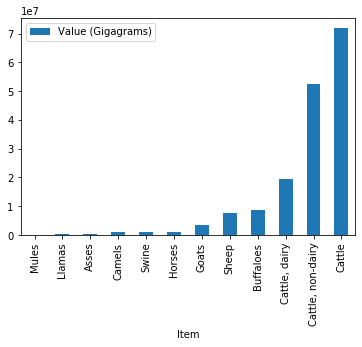

In [187]:
df_entric_fermentation_grouped_emission.sort_values("Value (Gigagrams)").plot.bar("Item")

In [190]:
merged

,Item,Value (Gigagrams),Value (Head),CO2eq emission per head
0,Asses,4.625699e+05,2.202714e+09,0.000210
1,Buffaloes,8.801912e+06,7.620703e+09,0.001155
2,Camels,1.014322e+06,1.050023e+09,0.000966
3,Cattle,7.192454e+07,6.736963e+10,0.001068
4,"Cattle, dairy",1.938441e+07,1.169170e+10,0.001658
5,"Cattle, non-dairy",5.254013e+07,5.567793e+10,0.000944
6,Goats,3.401133e+06,3.239174e+10,0.000105
7,Horses,1.218025e+06,3.222287e+09,0.000378
8,Llamas,2.108726e+05,3.403916e+08,0.000619
9,Mules,1.435338e+05,6.834943e+08,0.000210


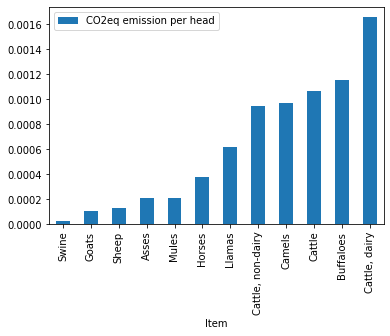

In [192]:
merged = pd.merge(df_entric_fermentation_grouped_emission,\
                  df_entric_fermentation_grouped_stock,\
                  on = "Item")
merged["CO2eq emission per head"] = merged["Value (Gigagrams)"] / merged["Value (Head)"]
merged.sort_values("CO2eq emission per head").plot.bar(x="Item",y="CO2eq emission per head")
        

In [148]:
df_manure_soils.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,1961,Head,1300000.0,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,1962,Head,851850.0,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,1963,Head,1001112.0,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,1965,Head,1300000.0,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,1966,Head,1200000.0,Official data


In [149]:
df_manure_soils.isna().any()

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year Code       False
Year            False
Unit            False
Value            True
Flag            False
dtype: bool

In [150]:
df_manure_soils[df_manure_soils["Value"].isna()]["Year"].unique()

array([2030, 2050])

In [151]:
df_manure_soils = df_manure_soils[df_manure_soils["Year"]<2030]

In [152]:
df_manure_soils["Element"].unique()

array(['Stocks', 'Manure (N content) (Manure applied)',
       'Implied emission factor for N2O (Manure applied)',
       'Direct emissions (N2O) (Manure applied)',
       'Direct emissions (CO2eq) (Manure applied)',
       'Indirect emissions (N2O) (Manure applied)',
       'Indirect emissions (CO2eq) (Manure applied)',
       'Emissions (N2O) (Manure applied)',
       'Emissions (CO2eq) (Manure applied)'], dtype=object)

In [153]:
split_manure_soils = split_on(df_manure_soils, "Element")
stocks_manure_soils_by_animals = split_manure_soils["Stocks"]
emission_manure_soils_by_animals = split_manure_soils["Emissions (CO2eq) (Manure applied)"]

In [154]:
emission_manure_soils_by_animals

,Country Code,Country,Item Code,Item,Element Code,Year Code,Year,Unit,Value,Flag
113057,2,Afghanistan,1107,Asses,72311,1961,1961,Gigagrams,9.8487,Calculated data
113058,2,Afghanistan,1107,Asses,72311,1962,1962,Gigagrams,6.4535,Calculated data
113059,2,Afghanistan,1107,Asses,72311,1963,1963,Gigagrams,7.5843,Calculated data
113060,2,Afghanistan,1107,Asses,72311,1964,1964,Gigagrams,8.7123,Calculated data
113061,2,Afghanistan,1107,Asses,72311,1965,1965,Gigagrams,9.8487,Calculated data
...,...,...,...,...,...,...,...,...,...,...
2004789,5873,OECD,1048,Swine,72311,2010,2010,Gigagrams,12852.0594,"Aggregate, may include official, semi-official..."
2004790,5873,OECD,1048,Swine,72311,2011,2011,Gigagrams,12790.8576,"Aggregate, may include official, semi-official..."
2004791,5873,OECD,1048,Swine,72311,2012,2012,Gigagrams,12692.1139,"Aggregate, may include official, semi-official..."
2004792,5873,OECD,1048,Swine,72311,2013,2013,Gigagrams,12586.6297,"Aggregate, may include official, semi-official..."


In [155]:
stocks_manure_soils_by_animals["Unit"].unique()

array(['Head'], dtype=object)

In [156]:
emission_manure_soils_by_animals["Unit"].unique()

array(['Gigagrams'], dtype=object)

In [157]:
stocks_manure_soils_by_animals.drop("Unit", axis=1, inplace=True)
emission_manure_soils_by_animals.drop("Unit", axis=1, inplace=True)
stocks_manure_soils_by_animals.rename(columns={"Value": "Value (Head)"}, inplace=True)
emission_manure_soils_by_animals.rename(columns={"Value": "Value (Gigagrams)"}, inplace=True)

In [158]:
emission_manure_soils_by_animals

,Country Code,Country,Item Code,Item,Element Code,Year Code,Year,Value (Gigagrams),Flag
113057,2,Afghanistan,1107,Asses,72311,1961,1961,9.8487,Calculated data
113058,2,Afghanistan,1107,Asses,72311,1962,1962,6.4535,Calculated data
113059,2,Afghanistan,1107,Asses,72311,1963,1963,7.5843,Calculated data
113060,2,Afghanistan,1107,Asses,72311,1964,1964,8.7123,Calculated data
113061,2,Afghanistan,1107,Asses,72311,1965,1965,9.8487,Calculated data
...,...,...,...,...,...,...,...,...,...
2004789,5873,OECD,1048,Swine,72311,2010,2010,12852.0594,"Aggregate, may include official, semi-official..."
2004790,5873,OECD,1048,Swine,72311,2011,2011,12790.8576,"Aggregate, may include official, semi-official..."
2004791,5873,OECD,1048,Swine,72311,2012,2012,12692.1139,"Aggregate, may include official, semi-official..."
2004792,5873,OECD,1048,Swine,72311,2013,2013,12586.6297,"Aggregate, may include official, semi-official..."


In [159]:
df_manure_soils["Item"].unique()

array(['Asses', 'Camels', 'Goats', 'Horses', 'Mules', 'Sheep',
       'Buffaloes', 'Ducks', 'Turkeys', 'Cattle, dairy',
       'Cattle, non-dairy', 'Chickens, broilers', 'Chickens, layers',
       'Swine, breeding', 'Swine, market', 'Llamas', 'All Animals',
       'Camels and Llamas', 'Cattle', 'Chickens', 'Mules and Asses',
       'Poultry Birds', 'Sheep and Goats', 'Swine'], dtype=object)

In [160]:
Animals = ['Asses', 'Camels', 'Cattle, dairy', 'Cattle, non-dairy', 'Goats', 'Horses','Mules', 'Sheep','Cattle',
           'Chickens', 'Poultry Birds','Buffaloes', 'Ducks','Turkeys', 'Swine', 'Llamas']

In [161]:
dict_elements = {"Country" : ["World"],"Item" : Animals}
columns = ["Country","Item"]
df_filter_stock = select_on(stocks_manure_soils_by_animals,columns,dict_elements)
df_filter_emission = select_on(emission_manure_soils_by_animals,columns,dict_elements)

In [162]:
df_manure_soils_grouped_stock = df_filter_stock.groupby(["Item"])\
                                ['Value (Head)'].sum().reset_index()
df_manure_soils_grouped_emission = df_filter_emission.groupby(["Item"])\
                                ['Value (Gigagrams)'].sum().reset_index()

In [163]:
df_manure_soils_grouped_stock

,Item,Value (Head)
0,Asses,2.202714e+09
1,Buffaloes,7.620703e+09
2,Camels,1.050023e+09
3,Cattle,6.736963e+10
4,"Cattle, dairy",1.169170e+10
5,"Cattle, non-dairy",5.567793e+10
6,Chickens,5.827768e+11
7,Ducks,3.387794e+10
8,Goats,3.239174e+10
9,Horses,3.222287e+09


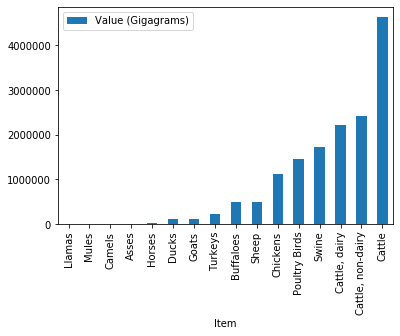

In [194]:
df_manure_soils_grouped_emission.sort_values("Value (Gigagrams)").plot.bar(x="Item",y="Value (Gigagrams)")

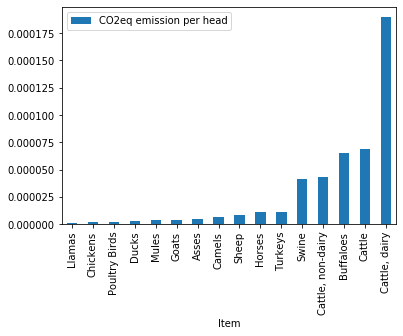

In [195]:
merged = pd.merge(df_manure_soils_grouped_emission,\
                  df_manure_soils_grouped_stock,\
                  on = "Item")
merged["CO2eq emission per head"] = merged["Value (Gigagrams)"] / merged["Value (Head)"]
merged.sort_values("CO2eq emission per head").plot.bar(x="Item",y="CO2eq emission per head")
        

In [167]:
df_manure_pasture.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1961,1961,Gigagrams,0.0953,Calculated data
1,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1962,1962,Gigagrams,0.0625,Calculated data
2,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1963,1963,Gigagrams,0.0734,Calculated data
3,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1964,1964,Gigagrams,0.0843,Calculated data
4,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1965,1965,Gigagrams,0.0953,Calculated data


In [168]:
df_manure_pasture.isna().any()

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year Code       False
Year            False
Unit            False
Value            True
Flag            False
dtype: bool

In [169]:
df_manure_pasture[df_manure_pasture["Value"].isna()]["Year"].unique()

array([2030, 2050])

In [170]:
df_manure_pasture = df_manure_pasture[df_manure_pasture["Year"]<2030]

In [171]:
df_manure_pasture["Element"].unique()

array(['Indirect emissions (N2O that leaches) (Manure on pasture)',
       'Indirect emissions (N2O that volatilises) (Manure on pasture)',
       'Manure (N content that leaches) (Manure on pasture)',
       'Manure (N content that volatilises) (Manure on pasture)',
       'Manure (N content) (Manure on pasture)',
       'Implied emission factor for N2O (Manure on pasture)',
       'Direct emissions (N2O) (Manure on pasture)',
       'Direct emissions (CO2eq) (Manure on pasture)',
       'Indirect emissions (N2O) (Manure on pasture)',
       'Indirect emissions (CO2eq) (Manure on pasture)',
       'Emissions (N2O) (Manure on pasture)',
       'Emissions (CO2eq) (Manure on pasture)', 'Stocks'], dtype=object)

In [172]:
split_manure_pasture = split_on(df_manure_pasture, "Element")
stocks_manure_pasture_by_animals = split_manure_pasture["Stocks"]
emission_manure_pasture_by_animals = split_manure_pasture["Emissions (CO2eq) (Manure on pasture)"]

In [173]:
emission_manure_pasture_by_animals

,Country Code,Country,Item Code,Item,Element Code,Year Code,Year,Unit,Value,Flag
618,2,Afghanistan,1107,Asses,72310,1961,1961,Gigagrams,187.1252,Calculated data
619,2,Afghanistan,1107,Asses,72310,1962,1962,Gigagrams,122.6174,Calculated data
620,2,Afghanistan,1107,Asses,72310,1963,1963,Gigagrams,144.1025,Calculated data
621,2,Afghanistan,1107,Asses,72310,1964,1964,Gigagrams,165.5338,Calculated data
622,2,Afghanistan,1107,Asses,72310,1965,1965,Gigagrams,187.1252,Calculated data
...,...,...,...,...,...,...,...,...,...,...
2940890,5873,OECD,1048,Swine,72310,2010,2010,Gigagrams,0.0000,"Aggregate, may include official, semi-official..."
2940891,5873,OECD,1048,Swine,72310,2011,2011,Gigagrams,0.0000,"Aggregate, may include official, semi-official..."
2940892,5873,OECD,1048,Swine,72310,2012,2012,Gigagrams,0.0000,"Aggregate, may include official, semi-official..."
2940893,5873,OECD,1048,Swine,72310,2013,2013,Gigagrams,0.0000,"Aggregate, may include official, semi-official..."


In [174]:
stocks_manure_pasture_by_animals["Unit"].unique()

array(['Head'], dtype=object)

In [175]:
emission_manure_pasture_by_animals["Unit"].unique()

array(['Gigagrams'], dtype=object)

In [176]:
stocks_manure_pasture_by_animals.drop("Unit", axis=1, inplace=True)
emission_manure_pasture_by_animals.drop("Unit", axis=1, inplace=True)
stocks_manure_pasture_by_animals.rename(columns={"Value": "Value (Head)"}, inplace=True)
emission_manure_pasture_by_animals.rename(columns={"Value": "Value (Gigagrams)"}, inplace=True)

In [177]:
emission_manure_pasture_by_animals

,Country Code,Country,Item Code,Item,Element Code,Year Code,Year,Value (Gigagrams),Flag
618,2,Afghanistan,1107,Asses,72310,1961,1961,187.1252,Calculated data
619,2,Afghanistan,1107,Asses,72310,1962,1962,122.6174,Calculated data
620,2,Afghanistan,1107,Asses,72310,1963,1963,144.1025,Calculated data
621,2,Afghanistan,1107,Asses,72310,1964,1964,165.5338,Calculated data
622,2,Afghanistan,1107,Asses,72310,1965,1965,187.1252,Calculated data
...,...,...,...,...,...,...,...,...,...
2940890,5873,OECD,1048,Swine,72310,2010,2010,0.0000,"Aggregate, may include official, semi-official..."
2940891,5873,OECD,1048,Swine,72310,2011,2011,0.0000,"Aggregate, may include official, semi-official..."
2940892,5873,OECD,1048,Swine,72310,2012,2012,0.0000,"Aggregate, may include official, semi-official..."
2940893,5873,OECD,1048,Swine,72310,2013,2013,0.0000,"Aggregate, may include official, semi-official..."


In [178]:
df_manure_pasture["Item"].unique()

array(['Asses', 'Camels', 'Cattle, dairy', 'Cattle, non-dairy',
       'Chickens, broilers', 'Chickens, layers', 'Goats', 'Horses',
       'Mules', 'Sheep', 'Buffaloes', 'Ducks', 'Swine, breeding',
       'Swine, market', 'Turkeys', 'Llamas', 'All Animals',
       'Camels and Llamas', 'Cattle', 'Chickens', 'Mules and Asses',
       'Poultry Birds', 'Sheep and Goats', 'Swine'], dtype=object)

In [179]:
Animals = ['Asses', 'Camels', 'Cattle, dairy', 'Cattle, non-dairy','Goats', 'Horses',
           'Mules', 'Sheep', 'Buffaloes', 'Ducks','Turkeys', 'Llamas','Cattle', 'Chickens',
           'Poultry Birds', 'Swine']

In [180]:
dict_elements = {"Country" : ["World"],"Item" : Animals}
columns = ["Country","Item"]
df_filter_stock = select_on(stocks_manure_pasture_by_animals,columns,dict_elements)
df_filter_emission = select_on(emission_manure_pasture_by_animals,columns,dict_elements)

In [181]:
df_manure_pasture_grouped_stock = df_filter_stock.groupby(["Item"])\
                                ['Value (Head)'].sum().reset_index()
df_manure_pasture_grouped_emission = df_filter_emission.groupby(["Item"])\
                                ['Value (Gigagrams)'].sum().reset_index()

In [182]:
df_manure_pasture_grouped_stock

,Item,Value (Head)
0,Asses,2.202714e+09
1,Buffaloes,7.620703e+09
2,Camels,1.050023e+09
3,Cattle,6.736963e+10
4,"Cattle, dairy",1.169170e+10
5,"Cattle, non-dairy",5.567793e+10
6,Chickens,5.827768e+11
7,Ducks,3.387794e+10
8,Goats,3.239174e+10
9,Horses,3.222287e+09


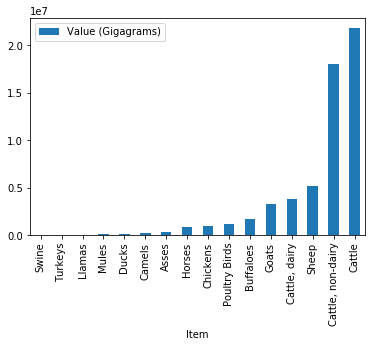

In [196]:
df_manure_pasture_grouped_emission.sort_values("Value (Gigagrams)").plot.bar(x="Item",y="Value (Gigagrams)")

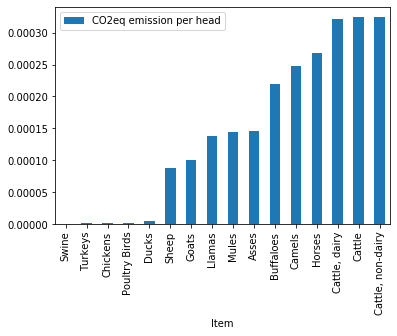

In [197]:
merged = pd.merge(df_manure_pasture_grouped_emission,\
                  df_manure_pasture_grouped_stock,\
                  on = "Item")
merged["CO2eq emission per head"] = merged["Value (Gigagrams)"] / merged["Value (Head)"]
merged.sort_values("CO2eq emission per headCO2eq emission per headdf_manure_management.isna().any()").plot.bar(x="Item",y="CO2eq emission per head")
        

In [199]:
df_manure_management.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,1961,Head,1300000.0,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,1962,Head,851850.0,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,1963,Head,1001112.0,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,1965,Head,1300000.0,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,1966,Head,1200000.0,Official data


In [200]:
df_manure_management.isna().any()

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year Code       False
Year            False
Unit            False
Value            True
Flag            False
dtype: bool

In [202]:
df_manure_management[df_manure_management["Value"].isna()]["Year"].unique()

array([2030, 2050])

In [203]:
df_manure_management = df_manure_management[df_manure_management["Year"]<2030]

In [204]:
df_manure_management["Element"].unique()

array(['Stocks', 'Manure (N content) (Manure management)',
       'Implied emission factor for CH4 (Manure management)',
       'Implied emission factor for N2O (Manure management)',
       'Emissions (CH4) (Manure management)',
       'Emissions (CO2eq) from CH4 (Manure management)',
       'Direct emissions (N2O) (Manure management)',
       'Indirect emissions (N2O) (Manure management)',
       'Emissions (N2O) (Manure management)',
       'Direct emissions (CO2eq) (Manure management)',
       'Indirect emissions (CO2eq) (Manure management)',
       'Emissions (CO2eq) from N2O (Manure management)',
       'Emissions (CO2eq) (Manure management)'], dtype=object)

In [207]:
split_manure_management = split_on(df_manure_management, "Element")
stocks_manure_management_by_animals = split_manure_management["Stocks"]
emission_manure_management_by_animals = split_manure_management["Emissions (CO2eq) (Manure management)"]

In [208]:
emission_manure_management_by_animals

,Country Code,Country,Item Code,Item,Element Code,Year Code,Year,Unit,Value,Flag
113281,2,Afghanistan,1107,Asses,72316,1961,1961,Gigagrams,19.8357,Calculated data
113282,2,Afghanistan,1107,Asses,72316,1962,1962,Gigagrams,12.9977,Calculated data
113283,2,Afghanistan,1107,Asses,72316,1963,1963,Gigagrams,15.2752,Calculated data
113284,2,Afghanistan,1107,Asses,72316,1964,1964,Gigagrams,17.5469,Calculated data
113285,2,Afghanistan,1107,Asses,72316,1965,1965,Gigagrams,19.8357,Calculated data
...,...,...,...,...,...,...,...,...,...,...
2831694,5873,OECD,1048,Swine,72316,2010,2010,Gigagrams,47340.1655,"Aggregate, may include official, semi-official..."
2831695,5873,OECD,1048,Swine,72316,2011,2011,Gigagrams,47474.6271,"Aggregate, may include official, semi-official..."
2831696,5873,OECD,1048,Swine,72316,2012,2012,Gigagrams,47091.4751,"Aggregate, may include official, semi-official..."
2831697,5873,OECD,1048,Swine,72316,2013,2013,Gigagrams,46648.5332,"Aggregate, may include official, semi-official..."


In [209]:
stocks_manure_management_by_animals["Unit"].unique()

array(['Head'], dtype=object)

In [210]:
emission_manure_management_by_animals["Unit"].unique()

array(['Gigagrams'], dtype=object)

In [211]:
stocks_manure_management_by_animals.drop("Unit", axis=1, inplace=True)
emission_manure_management_by_animals.drop("Unit", axis=1, inplace=True)
stocks_manure_management_by_animals.rename(columns={"Value": "Value (Head)"}, inplace=True)
emission_manure_management_by_animals.rename(columns={"Value": "Value (Gigagrams)"}, inplace=True)

In [212]:
emission_manure_management_by_animals

,Country Code,Country,Item Code,Item,Element Code,Year Code,Year,Value (Gigagrams),Flag
113281,2,Afghanistan,1107,Asses,72316,1961,1961,19.8357,Calculated data
113282,2,Afghanistan,1107,Asses,72316,1962,1962,12.9977,Calculated data
113283,2,Afghanistan,1107,Asses,72316,1963,1963,15.2752,Calculated data
113284,2,Afghanistan,1107,Asses,72316,1964,1964,17.5469,Calculated data
113285,2,Afghanistan,1107,Asses,72316,1965,1965,19.8357,Calculated data
...,...,...,...,...,...,...,...,...,...
2831694,5873,OECD,1048,Swine,72316,2010,2010,47340.1655,"Aggregate, may include official, semi-official..."
2831695,5873,OECD,1048,Swine,72316,2011,2011,47474.6271,"Aggregate, may include official, semi-official..."
2831696,5873,OECD,1048,Swine,72316,2012,2012,47091.4751,"Aggregate, may include official, semi-official..."
2831697,5873,OECD,1048,Swine,72316,2013,2013,46648.5332,"Aggregate, may include official, semi-official..."


In [213]:
df_manure_management["Item"].unique()

array(['Asses', 'Camels', 'Goats', 'Horses', 'Mules', 'Sheep',
       'Buffaloes', 'Ducks', 'Turkeys', 'Cattle, dairy',
       'Cattle, non-dairy', 'Chickens, broilers', 'Chickens, layers',
       'Swine, breeding', 'Swine, market', 'Llamas', 'All Animals',
       'Camels and Llamas', 'Cattle', 'Chickens', 'Mules and Asses',
       'Poultry Birds', 'Sheep and Goats', 'Swine'], dtype=object)

In [214]:
Animals = ['Asses', 'Buffaloes','Chickens' ,'Camels','Cattle', 'Cattle, dairy', 'Cattle, non-dairy','Ducks','Turkeys',
,'Chickens, layers','Goats', 'Horses','Llamas', 'Mules','Sheep','Swine','Swine, breeding',
           'Poultry Birds']

In [216]:
dict_elements = {"Country" : ["World"],"Item" : Animals}
columns = ["Country","Item"]
df_filter_stock = select_on(stocks_manure_management_by_animals,columns,dict_elements)
df_filter_emission = select_on(emission_manure_management_by_animals,columns,dict_elements)

In [217]:
df_manure_management_grouped_stock = df_filter_stock.groupby(["Item"])\
                                ['Value (Head)'].sum().reset_index()
df_manure_management_grouped_emission = df_filter_emission.groupby(["Item"])\
                                ['Value (Gigagrams)'].sum().reset_index()

In [218]:
df_manure_management_grouped_stock

,Item,Value (Head)
0,Asses,2.202714e+09
1,Buffaloes,7.620703e+09
2,Camels,1.050023e+09
3,Cattle,6.736963e+10
4,"Cattle, dairy",1.169170e+10
5,"Cattle, non-dairy",5.567793e+10
6,Chickens,5.827768e+11
7,"Chickens, broilers",3.720063e+11
8,"Chickens, layers",2.107705e+11
9,Ducks,3.387794e+10


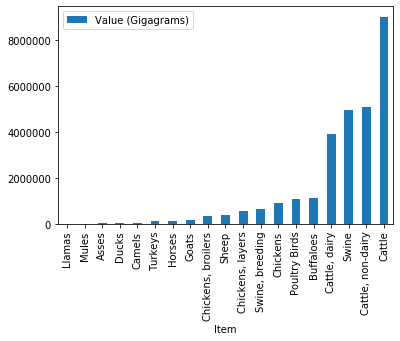

In [219]:
df_manure_management_grouped_emission.sort_values("Value (Gigagrams)").plot.bar(x="Item",y="Value (Gigagrams)")

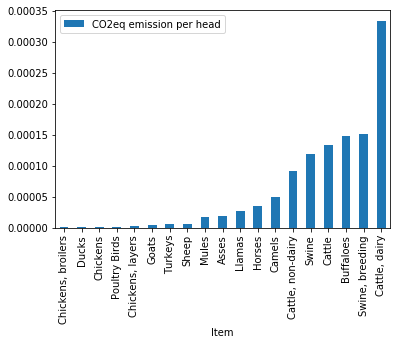

In [221]:
merged = pd.merge(df_manure_management_grouped_emission,\
                  df_manure_management_grouped_stock,\
                  on = "Item")
merged["CO2eq emission per head"] = merged["Value (Gigagrams)"] / merged["Value (Head)"]
merged.sort_values("CO2eq emission per head").plot.bar(x="Item",y="CO2eq emission per head")
        

In [ ]:
def clean_year(df, start, end):
    return df[(df["Year"] >= start) & (df["Year"] <= end)]

def select_on(df, columns, dict_elements):
    for column in columns:
        elements = dict_elements[column]
        df = df[df[column].isin(elements)]
    return df

